**PROJETO DE MANUTENÇÃO PREDITIVA INTELIGENTE EM MÁQUINAS INDUSTRIAIS**

**Neste projeto, desenvolvemos uma solução completa e robusta para manutenção preditiva, com foco em previsão da vida útil restante (RUL) e detecção antecipada de falhas críticas em máquinas industriais. Utilizando dados de sensores operacionais reais, combinamos algoritmos avançados de machine learning supervisionado, incluindo redes neurais, Random Forest, XGBoost e modelos híbridos de empilhamento (stacking). A abordagem proposta permite não só estimar com alta precisão quantos dias (e horas) restam até uma falha ocorrer, como também identificar com antecedência quais máquinas estão em risco iminente, gerando alertas acionáveis.**

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Carregando a base de dados
df = pd.read_csv('/content/factory_sensor_simulator_2040.csv')

In [3]:
# Observando
df.head()

,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,...,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,5,True,3,162.0,False,NaN,NaN,NaN,NaN,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,2,True,4,147.0,False,NaN,NaN,40.92,NaN,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,1,True,6,0.0,True,NaN,NaN,NaN,NaN,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,1,False,4,161.0,False,NaN,NaN,NaN,NaN,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,2,False,1,765.0,False,NaN,NaN,NaN,NaN,0


In [4]:
# Observando a quantidade de linhas e colunas
df.shape

(500000, 22)

In [5]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Machine_ID                  500000 non-null  object 
 1   Machine_Type                500000 non-null  object 
 2   Installation_Year           500000 non-null  int64  
 3   Operational_Hours           500000 non-null  int64  
 4   Temperature_C               500000 non-null  float64
 5   Vibration_mms               500000 non-null  float64
 6   Sound_dB                    500000 non-null  float64
 7   Oil_Level_pct               500000 non-null  float64
 8   Coolant_Level_pct           500000 non-null  float64
 9   Power_Consumption_kW        500000 non-null  float64
 10  Last_Maintenance_Days_Ago   500000 non-null  int64  
 11  Maintenance_History_Count   500000 non-null  int64  
 12  Failure_History_Count       500000 non-null  int64  
 13  AI_Supervision

In [6]:
# Dados estatísticos
df.describe()

,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
count,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,15156.000000,30340.000000,45624.000000,45214.000000,500000.000000
mean,2019.962360,50012.424764,59.997682,9.99114,75.003477,69.456568,64.114159,149.922161,182.257866,5.003128,2.000588,3.000840,452.422338,74.995513,119.917514,39.984794,499.760966,0.602098
std,11.829812,28861.849078,14.986973,4.99953,9.990791,18.847444,23.152998,79.955937,105.552537,2.238043,1.413087,1.730541,288.971269,10.035133,15.017048,9.989653,50.012057,1.203647
min,2000.000000,0.000000,-15.730000,-17.82000,23.650000,0.000000,0.000000,-222.740000,0.000000,0.000000,0.000000,0.000000,0.000000,34.970000,52.680000,-0.160000,296.440000,0.000000
25%,2010.000000,25055.000000,49.890000,6.62000,68.270000,56.540000,48.130000,96.090000,91.000000,3.000000,1.000000,2.000000,200.000000,68.250000,109.820000,33.200000,465.940000,0.000000
50%,2020.000000,49973.000000,60.000000,10.00000,75.000000,70.030000,65.010000,149.950000,182.000000,5.000000,2.000000,3.000000,451.000000,74.950000,119.860000,40.030000,499.770000,0.000000
75%,2030.000000,74995.000000,70.050000,13.36000,81.730000,83.540000,81.840000,203.900000,274.000000,6.000000,3.000000,4.000000,700.000000,81.682500,130.072500,46.750000,533.307500,1.000000
max,2040.000000,100000.000000,127.330000,32.47000,120.700000,100.000000,100.000000,544.200000,365.000000,18.000000,12.000000,13.000000,1133.000000,114.320000,185.380000,80.790000,694.170000,11.000000


In [7]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
Machine_ID,0
Machine_Type,0
Installation_Year,0
Operational_Hours,0
Temperature_C,0
Vibration_mms,0
Sound_dB,0
Oil_Level_pct,0
Coolant_Level_pct,0
Power_Consumption_kW,0


In [8]:
# Porcentagem de valores nulos por coluna
percentual_nulos = (df.isnull().sum() / len(df)) * 100
print(percentual_nulos.round(2))

Machine_ID                     0.00
Machine_Type                   0.00
Installation_Year              0.00
Operational_Hours              0.00
Temperature_C                  0.00
Vibration_mms                  0.00
Sound_dB                       0.00
Oil_Level_pct                  0.00
Coolant_Level_pct              0.00
Power_Consumption_kW           0.00
Last_Maintenance_Days_Ago      0.00
Maintenance_History_Count      0.00
Failure_History_Count          0.00
AI_Supervision                 0.00
Error_Codes_Last_30_Days       0.00
Remaining_Useful_Life_days     0.00
Failure_Within_7_Days          0.00
Laser_Intensity               96.97
Hydraulic_Pressure_bar        93.93
Coolant_Flow_L_min            90.88
Heat_Index                    90.96
AI_Override_Events             0.00
dtype: float64


In [9]:
# Excluindo as colunas que não iremos utilizar e com mais de 90% dos dados nulos
df.drop(columns=['Machine_ID', 'Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index'], inplace=True)

In [10]:
df

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,True,3,162.0,False,2
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,True,4,147.0,False,2
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,True,6,0.0,True,2
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,False,4,161.0,False,0
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,False,1,765.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,Vacuum_Packer,2011,14425,65.42,16.50,81.95,59.21,73.67,255.87,282,4,3,False,0,820.0,False,0
499996,Conveyor_Belt,2003,75501,44.83,12.88,64.94,73.69,29.25,198.37,208,4,1,False,4,34.0,False,0
499997,CMM,2039,19855,37.26,11.46,70.70,70.70,49.04,156.59,185,7,2,False,4,815.0,False,0
499998,Dryer,2035,86823,67.72,16.76,77.45,97.00,15.40,132.33,274,3,2,True,0,99.0,False,2


In [11]:
# Ver quantidade de valores únicos por coluna
valores_unicos = df.nunique().sort_values(ascending=False)
print(valores_unicos)

Operational_Hours             99328
Power_Consumption_kW          43440
Coolant_Level_pct              9984
Temperature_C                  9878
Oil_Level_pct                  9275
Sound_dB                       6806
Vibration_mms                  3604
Remaining_Useful_Life_days     1106
Last_Maintenance_Days_Ago       366
Installation_Year                41
Machine_Type                     33
Maintenance_History_Count        19
Error_Codes_Last_30_Days         14
Failure_History_Count            13
AI_Override_Events               12
AI_Supervision                    2
Failure_Within_7_Days             2
dtype: int64


Text(0, 0.5, 'Frequência')

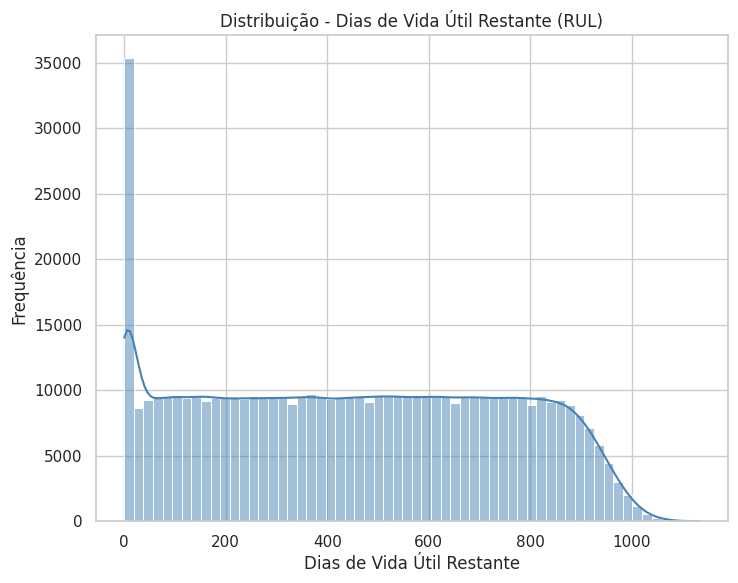

In [12]:
# Configurações de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 6)
# Distribuição do Remaining_Useful_Life_days
plt.subplot(1, 2, 1)
sns.histplot(df['Remaining_Useful_Life_days'], bins=60, kde=True, color='steelblue')
plt.title('Distribuição - Dias de Vida Útil Restante (RUL)')
plt.xlabel('Dias de Vida Útil Restante')
plt.ylabel('Frequência')

**Na distribuição acima vemos um pico muito grande à esquerda e uma cauda à direita, muitos casos com vida útil praticamente no fim.**

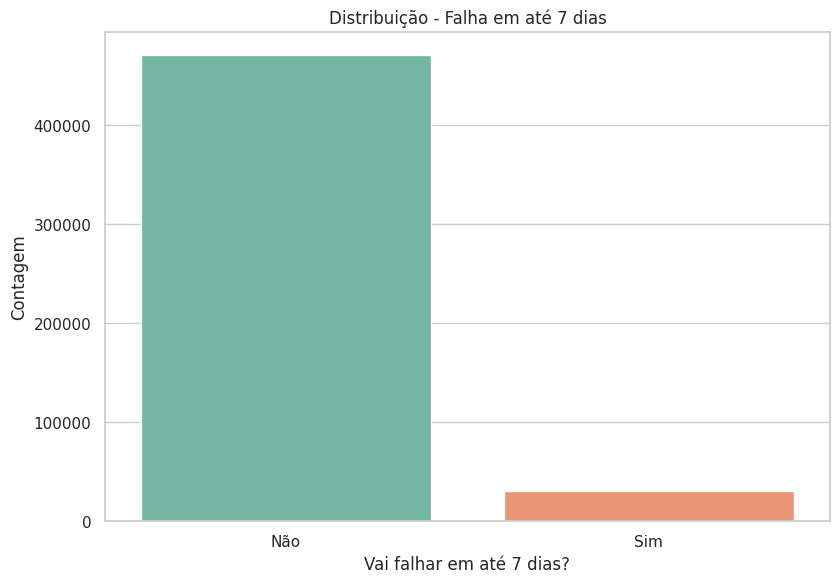

In [13]:
# Gráfico 2: Balanceamento da variável binária Failure_Within_7_Days
plt.subplot(1, 2, 2)
sns.countplot(x='Failure_Within_7_Days', data=df, palette='Set2')
plt.title('Distribuição - Falha em até 7 dias')
plt.xlabel('Vai falhar em até 7 dias?')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])

plt.tight_layout()
plt.show()

**No gráfico acima percebemos claramente que 450000 máquinas não falharão nos próximos  dias.**

**Agora vamos criar um gráfico para mostrar como os sensores se comportam quando a máquina está perto de falhar, por exemplo: vibração ou temperatura subindo, ou nível de óleo muito baixo.**

In [14]:
cols = [
    'Failure_Within_7_Days',
    'Temperature_C',
    'Vibration_mms',
    'Sound_dB',
    'Power_Consumption_kW',
    'Oil_Level_pct',
    'Coolant_Level_pct'
]

In [15]:
# Converter booleanos
df['Failure_Within_7_Days'] = df['Failure_Within_7_Days'].astype(int)

In [16]:
# Calcular médias por grupo
media_por_falha = df.groupby('Failure_Within_7_Days')[cols[1:]].mean().T
media_por_falha.columns = ['Sem Falha (0)', 'Com Falha (1)']
media_por_falha['Diferenca'] = media_por_falha['Com Falha (1)'] - media_por_falha['Sem Falha (0)']
media_por_falha = media_por_falha.sort_values('Diferenca', ascending=False)

In [17]:
# Preparar para gráfico
media_long = media_por_falha[['Sem Falha (0)', 'Com Falha (1)']].reset_index().melt(
    id_vars='index', var_name='Status de Falha', value_name='Média'
)
media_long.rename(columns={'index': 'Variável'}, inplace=True)

In [18]:
# Gráfico com Plotly
fig = px.bar(
    media_long,
    x='Variável',
    y='Média',
    color='Status de Falha',
    barmode='group',
    title='Comparativo de Sensores - Máquinas com e sem Falha em até 7 Dias',
    text_auto='.2f'
)

fig.update_layout(xaxis_title='Variável de Sensor', yaxis_title='Média', legend_title='Falha em 7 Dias')
fig.show()

**O gráfico acima nos mostra a média de cada sensor nas máquinas que não vão falhar nos próximos 7 dias e as que vão falhar. Percebemos que as máquinas perto de falhar trabalham com temperatura e vibração um pouco mais alta que o funcionamento normal.**

In [19]:
# Contar frequência de cada tipo de máquina
frequencia_tipos = df['Machine_Type'].value_counts().reset_index()
frequencia_tipos.columns = ['Machine_Type', 'Quantidade']

fig = px.bar(
    frequencia_tipos,
    x='Machine_Type',
    y='Quantidade',
    title='Quantidade por Tipo de Máquina',
    text_auto=True
)

fig.update_layout(
    xaxis_title='Tipo de Máquina',
    yaxis_title='Quantidade de Registros',
    xaxis_tickangle=-45
)

fig.show()

In [20]:
# Filtrar apenas as máquinas que vão falhar em até 7 dias
df_falhas = df[df["Failure_Within_7_Days"] == True]

# Contar quantas falhas por tipo de máquina
falhas_por_tipo = df_falhas["Machine_Type"].value_counts().reset_index()
falhas_por_tipo.columns = ["Machine_Type", "Máquinas com Falha em 7 Dias"]

# Gráfico interativo
fig = px.bar(
    falhas_por_tipo,
    x="Machine_Type",
    y="Máquinas com Falha em 7 Dias",
    title="Máquinas com Falha em Até 7 Dias por Tipo de Máquina",
    text_auto=True
)

fig.update_layout(
    xaxis_title="Tipo de Máquina",
    yaxis_title="Quantidade de Máquinas com Falha",
    xaxis_tickangle=-45
)

fig.show()

**Proporção (%) de Máquinas com Falha em Até 7 Dias por Tipo de Máquina.**

In [21]:
# Total de máquinas por tipo
total_por_tipo = df["Machine_Type"].value_counts().reset_index()
total_por_tipo.columns = ["Machine_Type", "Total"]

In [22]:
# Total de falhas por tipo
falhas = df[df["Failure_Within_7_Days"] == True]
falhas_por_tipo = falhas["Machine_Type"].value_counts().reset_index()
falhas_por_tipo.columns = ["Machine_Type", "Com_Falha"]

In [23]:
# Juntar os dois
df_proporcao = pd.merge(total_por_tipo, falhas_por_tipo, on="Machine_Type", how="left")
df_proporcao["Com_Falha"] = df_proporcao["Com_Falha"].fillna(0)

In [24]:
# Calcular proporção de falhas por tipo
df_proporcao["Proporcao_Falha_%"] = (df_proporcao["Com_Falha"] / df_proporcao["Total"]) * 100

In [25]:
# Ordenar por proporção
df_proporcao = df_proporcao.sort_values("Proporcao_Falha_%", ascending=False)

In [26]:
fig = px.bar(
    df_proporcao,
    x="Machine_Type",
    y="Proporcao_Falha_%",
    title="Proporção de Máquinas com Falha em Até 7 Dias por Tipo de Máquina (%)",
    text_auto=".2f",
    color="Proporcao_Falha_%"
)

fig.update_layout(
    xaxis_title="Tipo de Máquina",
    yaxis_title="Proporção de Falhas (%)",
    xaxis_tickangle=-45,
    coloraxis_colorbar=dict(title="% de Falha")
)

fig.show()

**Acima percebemos a porcentagem de falha iminente de cada modelo de máquina especificamente a marca Automated_Screwdriver tem 6.43% de chances de falha iminente, ou seja a cada 100 máquinas desta marca 6 corresm o risco de falha em 7 dias.**

**Vamos criar um gráfico para observar se as máquinas mais velhas têm maior probabilidade de falha iminente.**

In [27]:
# Criar a idade da máquina (considerando que estamos em 2040)
df["Machine_Age"] = 2040 - df["Installation_Year"]

In [28]:
# Garantir que a coluna de falha está em formato numérico
df["Failure_Within_7_Days"] = df["Failure_Within_7_Days"].astype(int)

In [29]:
# Agrupar por idade da máquina e calcular proporção de falhas
falha_por_idade = df.groupby("Machine_Age").agg(
    total_maquinas=("Failure_Within_7_Days", "count"),
    falhas=("Failure_Within_7_Days", "sum")
).reset_index()

falha_por_idade["Proporcao_Falha_%"] = (falha_por_idade["falhas"] / falha_por_idade["total_maquinas"]) * 100
falha_por_idade["Proporcao_Falha_%"] = falha_por_idade["Proporcao_Falha_%"].round(2)

In [30]:
# Criar gráfico interativo
fig = px.bar(
    falha_por_idade,
    x="Machine_Age",
    y="Proporcao_Falha_%",
    text="Proporcao_Falha_%",
    title="Proporção de Falhas em Até 7 Dias por Idade da Máquina",
    labels={"Machine_Age": "Idade da Máquina (anos)", "Proporcao_Falha_%": "Probabilidade de Falha (%)"},
    color="Proporcao_Falha_%",
    color_continuous_scale="OrRd"
)

fig.update_layout(
    xaxis_title="Idade da Máquina (anos)",
    yaxis_title="Probabilidade de Falha (%)",
    coloraxis_colorbar=dict(title="% de Falha"),
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()


**O gráfico acima mostra a probabilidade de uma máquina falhar nos próximos 7 dias em função da sua idade (em anos de operação).**

**Notamos que as máquinas entre 30–36 anos tem picos de 6.35%, provavelmente estão operando no limite ou com baixa eficiência. Máquinas entre 5–15 anos e depois de 30 anos precisam ser monitoradas com mais atenção pois apresentam maior chance de falha iminente, talvez por desgaste não tratado ou fim de ciclo produtivo**

**Baseado no que vimos, vamos criar uma variável para capturar o risco histórico de falha com base na idade da máquina. A ideia é transformar a variável Machine_Age (idade em anos) em uma informação mais inteligente e diretamente relacionada à falha, nesta nova variável Prob_Falha_Idade, vamos informar a média que ela tem de falhar em 7 dias.**

In [31]:
# Gerar tabela de proporção histórica de falha por idade
df_risco_idade = df.groupby("Machine_Age")["Failure_Within_7_Days"].mean().reset_index()
df_risco_idade.rename(columns={"Failure_Within_7_Days": "Prob_Falha_Idade"}, inplace=True)

In [32]:
# Arredondar para 4 casas decimais
df_risco_idade["Prob_Falha_Idade"] = df_risco_idade["Prob_Falha_Idade"].round(4)

In [33]:
# Fazer merge com o dataset original para adicionar essa feature
df = df.merge(df_risco_idade, on="Machine_Age", how="left")

In [34]:
# Ver resultado
print(df[["Machine_Age", "Prob_Falha_Idade"]].head(10))

   Machine_Age  Prob_Falha_Idade
0           13            0.0595
1            8            0.0594
2           37            0.0626
3           33            0.0595
4           24            0.0594
5           39            0.0571
6           15            0.0608
7           35            0.0578
8           20            0.0588
9           11            0.0612


In [35]:
df.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events,Machine_Age,Prob_Falha_Idade
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,True,3,162.0,0,2,13,0.0595
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,True,4,147.0,0,2,8,0.0594
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,True,6,0.0,1,2,37,0.0626
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,False,4,161.0,0,0,33,0.0595
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,False,1,765.0,0,0,24,0.0594


**Agora vamos visualizar os principais sensores (Temperatura, Vibração, Som, Óleo, Coolant, Potência) comparando as médias por tipo de máquina.**

In [36]:
sensores = [
    "Temperature_C", "Vibration_mms", "Sound_dB",
    "Oil_Level_pct", "Coolant_Level_pct", "Power_Consumption_kW"
]

In [37]:
# Calcular média e desvio padrão por tipo de máquina
sensor_mean = df.groupby("Machine_Type")[sensores].mean()
sensor_std = df.groupby("Machine_Type")[sensores].std()

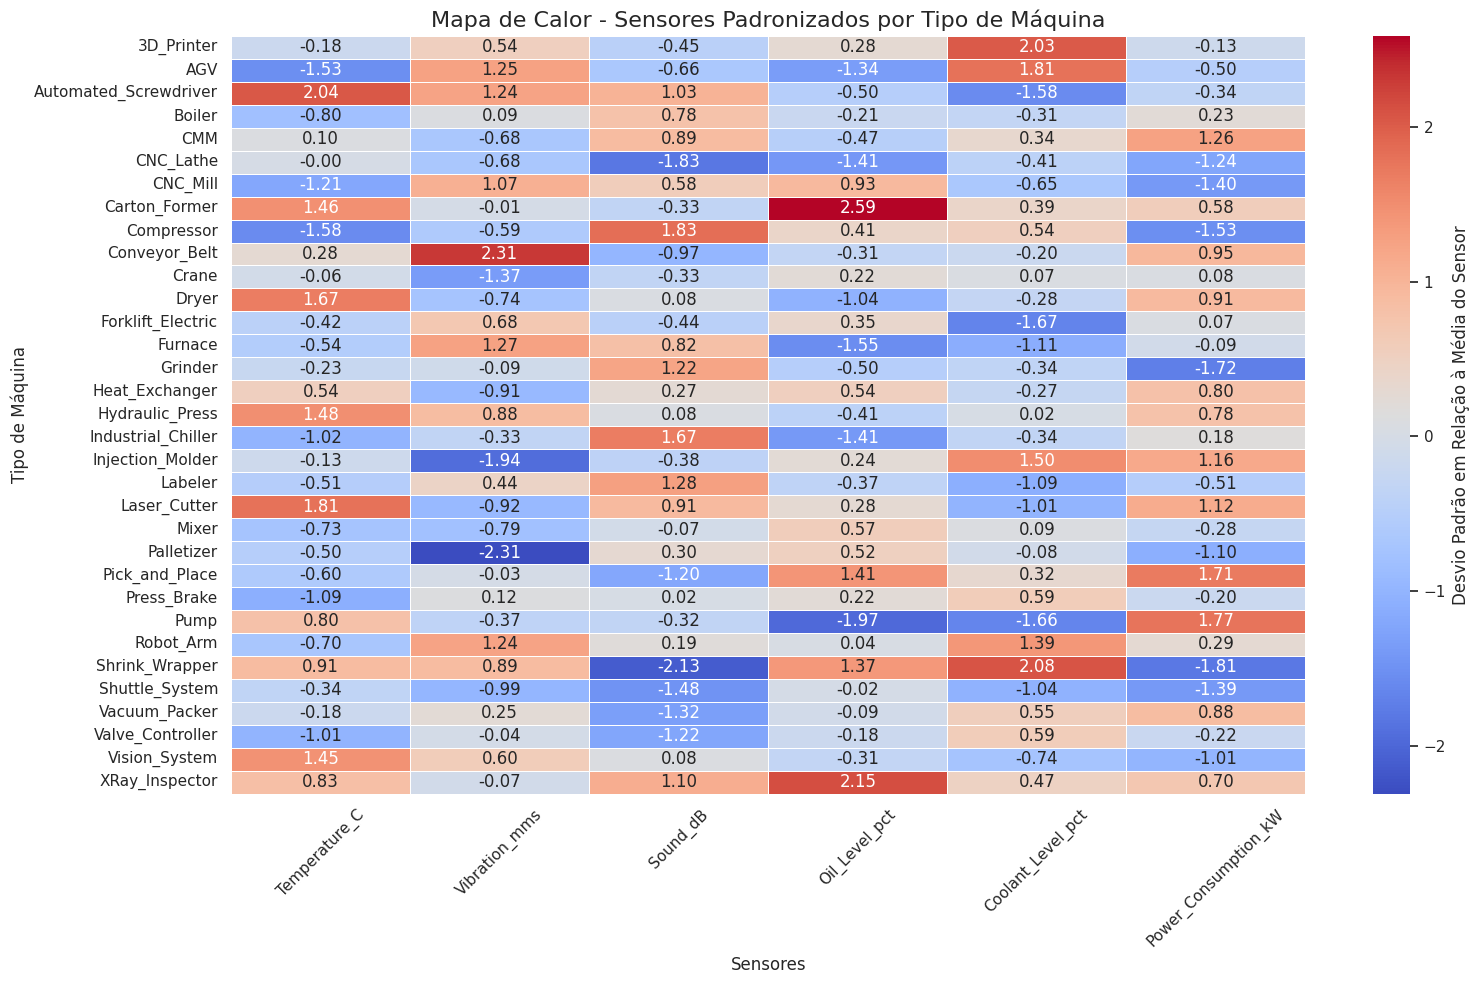

In [38]:
# Agrupamento por tipo de máquina (médias)
sensor_grouped = df.groupby("Machine_Type")[sensores].mean()

# Padronizar os valores (Z-score por sensor)
sensor_grouped_scaled = (sensor_grouped - sensor_grouped.mean()) / sensor_grouped.std()

# Plotar heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(sensor_grouped_scaled, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5,
            cbar_kws={"label": "Desvio Padrão em Relação à Média do Sensor"})

plt.title("Mapa de Calor - Sensores Padronizados por Tipo de Máquina", fontsize=16)
plt.xlabel("Sensores", fontsize=12)
plt.ylabel("Tipo de Máquina", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**NO heatmap acima vamos destacar os sensores que estão acima do z-score (é uma medida que mostra quantos desvios padrão um valor está distante da média) (em vermelho +2) e azul (abaixo da média -2) sendo 0 a média geral.**

In [39]:
# Variáveis operacionais confiáveis
variaveis = [
    "Operational_Hours", "Power_Consumption_kW", "Last_Maintenance_Days_Ago",
    "Maintenance_History_Count", "Failure_History_Count", "Error_Codes_Last_30_Days"
]

In [40]:
# Agrupando por falha e calcular médias
medias = df.groupby("Failure_Within_7_Days")[variaveis].mean().T
medias.columns = ["Sem Falha", "Com Falha"]
medias = medias.round(2)
medias.reset_index(inplace=True)
medias.rename(columns={"index": "Variável"}, inplace=True)

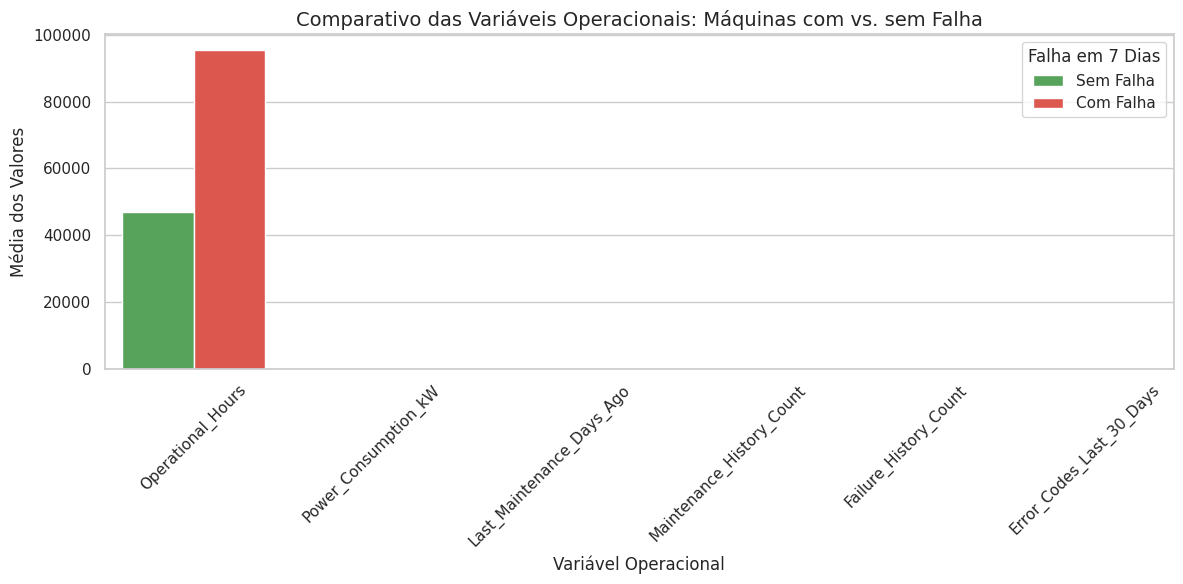

In [41]:
# Plot do gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=medias.melt(id_vars="Variável", var_name="Grupo", value_name="Média"),
    x="Variável", y="Média", hue="Grupo", palette=["#4CAF50", "#F44336"]
)

plt.title("Comparativo das Variáveis Operacionais: Máquinas com vs. sem Falha", fontsize=14)
plt.ylabel("Média dos Valores")
plt.xlabel("Variável Operacional")
plt.xticks(rotation=45)
plt.legend(title="Falha em 7 Dias")
plt.tight_layout()
plt.show()


**No gráfico acima percebemos que as máquinas que falharam tem mais do que o dobro das horas de funcionamento o que indica um maior desgaste com este acúmulo de uso. As outras variáveis por estarem em uma escala muito menor, acabaram com valores acatados no gráfico, por isso, vamos montar outro para continuar a análise.**

In [42]:
# Variáveis operacionais (excluindo Operational_Hours)
variaveis_2 = [
    "Power_Consumption_kW", "Last_Maintenance_Days_Ago",
    "Maintenance_History_Count", "Failure_History_Count", "Error_Codes_Last_30_Days"
]

In [43]:
# Agrupar por falha e calcular médias
medias_2 = df.groupby("Failure_Within_7_Days")[variaveis_2].mean().T
medias_2.columns = ["Sem Falha", "Com Falha"]
medias_2 = medias_2.round(2)
medias_2.reset_index(inplace=True)
medias_2.rename(columns={"index": "Variável"}, inplace=True)

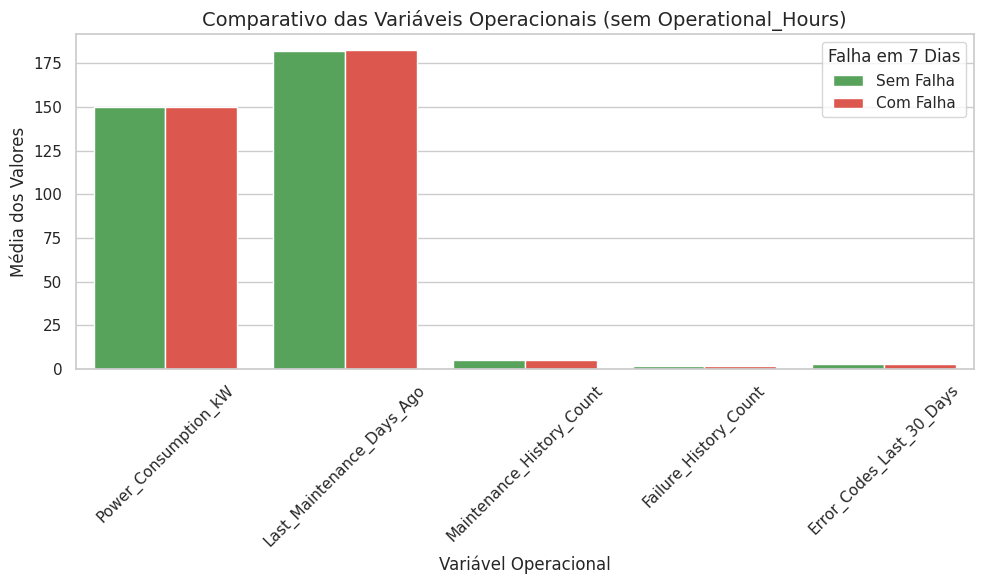

In [44]:
# Plot do gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=medias_2.melt(id_vars="Variável", var_name="Grupo", value_name="Média"),
    x="Variável", y="Média", hue="Grupo", palette=["#4CAF50", "#F44336"]
)

plt.title("Comparativo das Variáveis Operacionais (sem Operational_Hours)", fontsize=14)
plt.ylabel("Média dos Valores")
plt.xlabel("Variável Operacional")
plt.xticks(rotation=45)
plt.legend(title="Falha em 7 Dias")
plt.tight_layout()
plt.show()


**Acima vemos as outras variáveis de forma detalhada e percebemos que Nnm toda variável operacional traz valor direto. Algumas, como Power_Consumption_kW, não diferenciam falha ou não nesse horizonte de 7 dias.**

**Com base nos padrões visuais e estatísticos observados nos gráficos, vamos criar features derivadas que capturam sinais de risco operacional.**

**Vamos criar uma flag para identificar máquinas que á apresentaram falhas antes, pois as máquinas que já falharam no passado, tem maior chance de falhar novamente. Isso vai ajudar o modelo a capturar máquinas com um histórico ruim.**

In [45]:
# Cria flag para identificar máquinas que já apresentaram falha antes
df["is_high_failure_history"] = (df["Failure_History_Count"] > 0).astype(int)

**Códigos de erro recentes podem ser sinais de pré-falha. Mesmo que sutis, eles aparecem mais no grupo com falha. Vai ajudar o modelo a capturar sinais iminentes**


In [46]:
# Presença de erro recente
df["is_error_recent"] = (df["Error_Codes_Last_30_Days"] > 0).astype(int)

**Caso a máquina tenha passado por muitas manutenções, pode indicar desgaste excessivo ou problema persistente**

In [47]:
# Manutenção frequente
df["is_frequent_maintenance"] = (df["Maintenance_History_Count"] >= 5).astype(int)

**Flag para relacionar o esforço de manutenção com o histórico de falhas, pois uma razão baixa pode indicar que a manutenção não está resolvendo os problemas, ou que a máquina é nova e já apresenta falhas.**

In [48]:
# Razão entre manutenção e falha
df["maintenance_to_failure_ratio"] = df["Maintenance_History_Count"] / (df["Failure_History_Count"] + 1)

**Vamos combinar 2 fatores de risco detectados visualmente no gráfico pode representar um "cluster crítico" de máquinas em estado degradado.Uma categorização dos tipos de máquina com maior incidência de falhas.**

In [49]:
# Perfil de risco cruzado
df["perfil_risco_operacional"] = (
    (df["Failure_History_Count"] > 0) &
    (df["Error_Codes_Last_30_Days"] > 0)
).astype(int)

In [50]:
df.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,...,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events,Machine_Age,Prob_Falha_Idade,is_high_failure_history,is_error_recent,is_frequent_maintenance,maintenance_to_failure_ratio,perfil_risco_operacional
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,...,162.0,0,2,13,0.0595,1,1,0,0.666667,1
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,...,147.0,0,2,8,0.0594,1,1,1,1.666667,1
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,...,0.0,1,2,37,0.0626,1,1,0,0.500000,1
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,...,161.0,0,0,33,0.0595,1,1,0,2.000000,1
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,...,765.0,0,0,24,0.0594,1,1,0,1.333333,1


**No próximo passo vamos criar um boxplot com as variáveis contínuas (que são variáveis que vêm de medições físicas, como temperatura, consumo, horas, vibração etc) para analisar os outliers.**

In [51]:
# Variáveis que vamos analisar
variaveis_3 = [
    "Operational_Hours", "Power_Consumption_kW", "Last_Maintenance_Days_Ago",
    "Maintenance_History_Count", "Failure_History_Count", "Error_Codes_Last_30_Days"
]

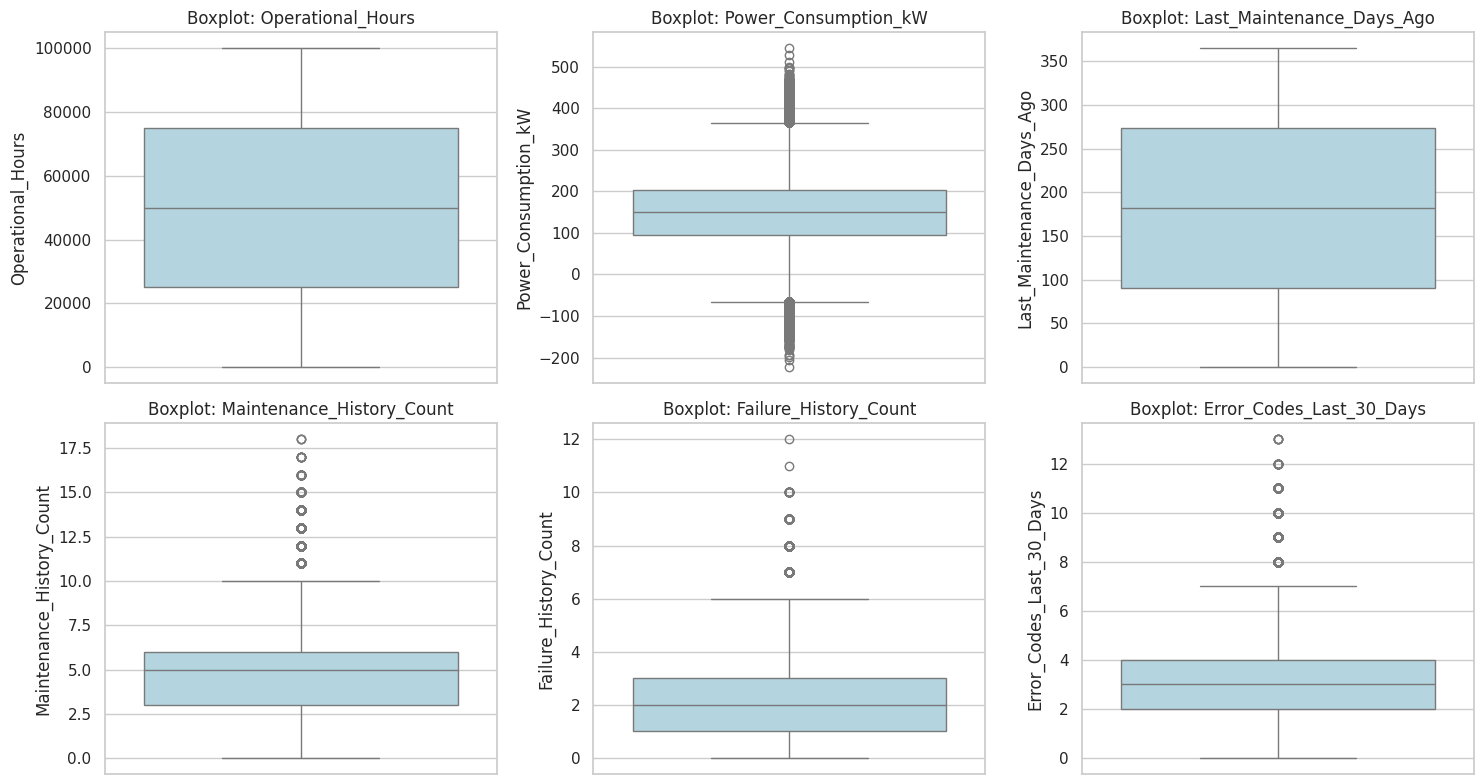

In [52]:
# Detectar outliers e exibir boxplots
outlier_summary = {}

plt.figure(figsize=(15, 8))
for i, var in enumerate(variaveis_3):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[var], color='lightblue')
    plt.title(f'Boxplot: {var}')

    # Cálculo do IQR
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Conta os outliers
    outliers = df[(df[var] < lower) | (df[var] > upper)]
    outlier_summary[var] = len(outliers)

plt.tight_layout()
plt.show()

In [53]:
# Exibir resumo de contagem de outliers
print("Quantidade de outliers por variável:")
for var, count in outlier_summary.items():
    print(f"{var}: {count} valores fora do intervalo")

Quantidade de outliers por variável:
Operational_Hours: 0 valores fora do intervalo
Power_Consumption_kW: 3513 valores fora do intervalo
Last_Maintenance_Days_Ago: 0 valores fora do intervalo
Maintenance_History_Count: 6936 valores fora do intervalo
Failure_History_Count: 2273 valores fora do intervalo
Error_Codes_Last_30_Days: 5857 valores fora do intervalo


**Agora vamos criar as flags de outliers e risco operacional, baseadas diretamente no que vimos nos boxplots.**

In [54]:
# Função auxiliar para gerar flags via IQR
def gerar_flag_outlier(df, coluna, nome_flag):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    df[nome_flag] = ((df[coluna] < lim_inf) | (df[coluna] > lim_sup)).astype(int)
    return df

**Potência negativa não faz sentido, pode indicar erro do sensor. Foram encontrados 3.513 valores negativos na variável 'Power_Consumption_kW', o que representa apenas 0,7% do total de registros. Como esse valor é fisicamente inválido e pode distorcer estatísticas ou modelos, optamos por eliminá-los diretamente nesta etapa de pré-processamento.**

In [55]:
# Remover valores negativos de consumo
df = df[df["Power_Consumption_kW"] >= 0]

**Muitas manutenções indicam desgaste acumulado, máquina problemática ou uso intenso. Pode preceder falha. Esta flag vai marcar máquinas com volume de manutenção muito acima do normal**

In [56]:
# Manutenção acima do normal
df = gerar_flag_outlier(df, "Maintenance_History_Count", "is_heavily_maintained")

**Flag para apontar reincidência de falhas. É padrão cíclico de risco.**

In [57]:
# Falhas recorrentes
df = gerar_flag_outlier(df, "Failure_History_Count", "has_repeated_failures")

**Sinaliza excesso de erros técnicos recentes, mesmo antes da falha real podem sinalizar comportameto crítico.**

In [58]:
# Alertas recentes
df = gerar_flag_outlier(df, "Error_Codes_Last_30_Days", "has_high_error_rate")

**Identifica ineficiência energética: máquinas que consomem muito para operar pouco podem estar prestes a falhar ou desreguladas.**

In [59]:
# Consumo por Hora
df['kW_per_hour'] = df['Power_Consumption_kW'] / (df['Operational_Hours'] + 1)

**temperatura relativa é uma razão entre aquecimento e vibração. Quando a temperatura sobe sem aumentar a vibração proporcionalmente, pode indicar sobrecarga térmica isolada (ex: problema no resfriamento).**

In [60]:
# Temperatura relativa à vibração
df['Temp_to_Vibration'] = df['Temperature_C'] / (df['Vibration_mms'] + 1e-3)

**Soma dos fluidos essenciais. A operação segura depende de bons níveis gerais de fluido. Valor baixo indica risco.**

In [61]:
# Nível combinado dos fluidos
df['Fluid_Level_Combined'] = df['Oil_Level_pct'] + df['Coolant_Level_pct']

**Proporção entre tempo sem manutenção e quantidade de erros. Se a máquina está há muito tempo sem manutenção e acumulando erros, o risco de falha cresce. Essa feature capta isso automaticamente.**

In [62]:
# Tempo desde manutenção dividido por erros recentes
df['DaysSinceMaint_to_Errors'] = df['Last_Maintenance_Days_Ago'] / (df['Error_Codes_Last_30_Days'] + 1)

**Quanto de energia é desperdiçada por erro recente. Pode indicar comportamentos anômalos em máquinas que estão com falhas energéticas crescentes, sem correção imediata.**

In [63]:
# Energia consumida por erro recente
df['kW_per_Error'] = df['Power_Consumption_kW'] / (df['Error_Codes_Last_30_Days'] + 1)

**Aplicação de log na contagem de manutenções. Reduz o peso de outliers e normaliza a variável. Máquinas com histórico grande de manutenção podem ter comportamento diferente, tanto melhor quanto pior.**

In [64]:
# Frequência de manutenção ajustada (log transform)
df['Log_Maint_History'] = np.log1p(df['Maintenance_History_Count'])

**Multiplicação entre manutenções e falhas. Permite captar padrões de manutenção ineficaz: se mesmo com muitas manutenções a máquina falha, há algo errado.**

In [65]:
# Interação entre manutenção e falha prévia
df['Maint_x_Failure'] = df['Maintenance_History_Count'] * df['Failure_History_Count']

**Quanto de energia está sendo dissipada em forma de ruído. Ruído excessivo pode indicar atrito, desalinhamento, ou esforço mecânico desnecessário.**

In [66]:
# Consumo ajustado pelo ruído (indicando possível esforço mecânico)
df['kW_per_dB'] = df['Power_Consumption_kW'] / (df['Sound_dB'] + 1)

**Diferença direta entre os níveis dos dois principais fluidos. Um desequilíbrio entre os dois pode afetar o desempenho térmico da máquina.**

In [67]:
# Diferença entre os níveis de óleo e fluido de refrigeração
df['Diff_Oil_Coolant'] = df['Oil_Level_pct'] - df['Coolant_Level_pct']

**Score customizado ponderando sensores críticos (temperatura, vibração, som e níveis de fluido). É uma forma de condensar 5 variáveis em uma métrica robusta, útil para a rede neural.**

In [68]:
# Score de Estresse Operacional
df['Stress_Score'] = (
    df['Temperature_C'] * 0.3 +
    df['Vibration_mms'] * 0.2 +
    df['Sound_dB'] * 0.2 +
    (100 - df['Oil_Level_pct']) * 0.15 +
    (100 - df['Coolant_Level_pct']) * 0.15
)

In [69]:
df.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,...,kW_per_hour,Temp_to_Vibration,Fluid_Level_Combined,DaysSinceMaint_to_Errors,kW_per_Error,Log_Maint_History,Maint_x_Failure,kW_per_dB,Diff_Oil_Coolant,Stress_Score
0,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,...,0.001039,5.745247,105.50,38.250000,21.237500,1.609438,20,1.002715,-31.98,55.5040
1,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,...,0.002062,3.890334,162.13,27.200000,30.922000,1.791759,10,1.981164,37.87,41.5825
2,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,...,0.000552,2.086960,78.92,36.857143,7.414286,0.693147,1,0.740582,7.00,51.6230
3,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,...,0.000987,5.147403,143.84,8.600000,15.122000,1.609438,4,0.873296,45.96,47.1350
4,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,...,0.010777,9.674282,101.34,173.000000,112.465000,1.609438,8,2.301781,-6.22,47.8580


**Vamos criar um heatmap de correlação.**

In [70]:
# Seleciona apenas colunas numéricas (float e int)
df_numericas = df.select_dtypes(include=['int64', 'float64'])

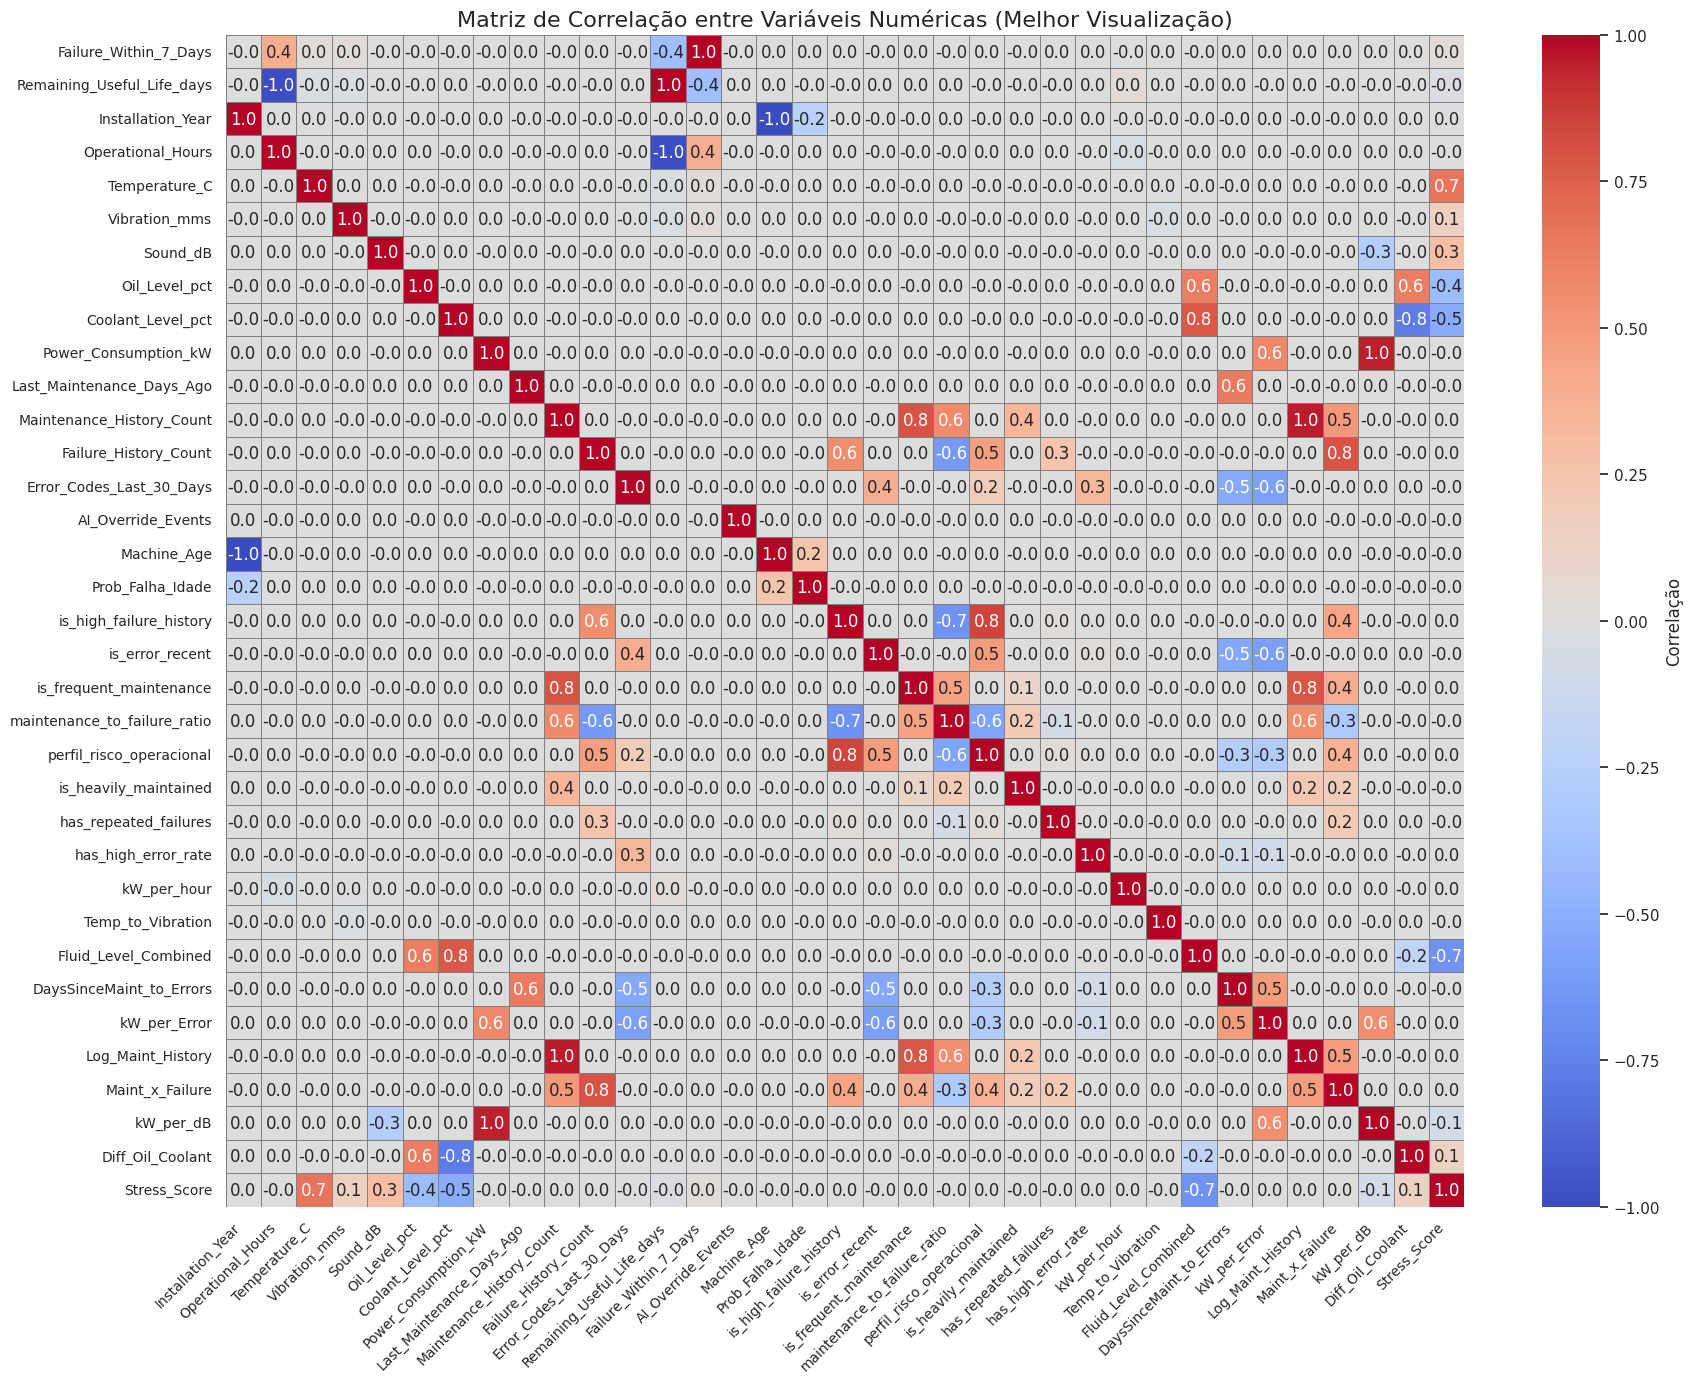

In [71]:
# Calcular correlação
correlacoes = df_numericas.corr()

# Ordenar colocando as variáveis alvo no topo
alvos = ['Failure_Within_7_Days', 'Remaining_Useful_Life_days']
correlacoes = correlacoes.loc[alvos + [c for c in correlacoes.columns if c not in alvos]]

plt.figure(figsize=(18, 14))
sns.heatmap(
    correlacoes,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    center=0,
    cbar_kws={'label': 'Correlação'}
)

plt.title("Matriz de Correlação entre Variáveis Numéricas (Melhor Visualização)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**Baseado na matriz de correlação acima, removeremos variáveis redundantes com alta colinearidade ou baixa contribuição preditiva direta. Isso ajuda a reduzir o risco de overfitting e melhora a estabilidade dos modelos.**

**Vamos descartar:**

**'Installation_Year' e 'Machine_Age', por estarem fortemente correlacionadas com 'Operational_Hours';**

**'is_high_failure_history' e 'has_high_error_rate', cujas informações já estão embutidas na flag 'perfil_risco_operacional';**

**'Prob_Falha_Idade', por sobreposição com variáveis temporais mais informativas.**


In [72]:
# Removendo colunas não relevantes
df.drop(columns=[
    'Machine_ID', 'Laser_Intensity', 'Hydraulic_Pressure_bar',
    'Coolant_Flow_L_min', 'Heat_Index', 'Installation_Year',
    'Machine_Age', 'is_high_failure_history', 'has_high_error_rate', 'Prob_Falha_Idade'
], inplace=True, errors='ignore')

In [73]:
# Criando variável Machine_Age novamente para visualização posterior (não será usada)
df["Machine_Age"] = 2040 - df["Installation_Year"] if "Installation_Year" in df.columns else 0

**Vamos transformar a variável alvo 'Remaining_Useful_Life_days_log' em log1p para deixar a distribuição mais parecida com uma normal, diminuir o impacto dos outliers e para melhorar a estabilidade numérica, pois ajuda o modelo a prever com mais precisão os valores pequenos, que são os mais importantes para alertar manutenção urgente.**

In [74]:
# Transformando variável alvo com log1p
df['Remaining_Useful_Life_days_log'] = np.log1p(df['Remaining_Useful_Life_days'])

In [75]:
# Separando a variável alvo
X = df.drop(columns=['Remaining_Useful_Life_days', 'Remaining_Useful_Life_days_log'])  # y original e y log
y = df['Remaining_Useful_Life_days_log']

In [76]:
# OneHotEncoder em Machine_Type
if 'Machine_Type' in X.columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(X[['Machine_Type']])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Machine_Type']), index=X.index)
    X = pd.concat([X.drop(columns='Machine_Type'), encoded_df], axis=1)

In [77]:
# Dividindo em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [78]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [79]:
print(f"TREINO: {X_train.shape}, VALIDAÇÃO: {X_val.shape}, TESTE: {X_test.shape}")

TREINO: (339377, 64), VALIDAÇÃO: (72724, 64), TESTE: (72724, 64)


**Vamos utilizar um modelo híbrido baseado em stacking para prever a vida útil restante das máquinas (RUL). Essa abordagem combina três modelos distintos: uma rede neural, capaz de aprender padrões não lineares complexos; um Random Forest, conhecido por sua robustez e boa interpretação de variáveis; e o XGBoost, um modelo de boosting extremamente eficaz para dados estruturados. Cada modelo faz sua própria previsão, e em seguida usamos uma regressão linear como meta-modelo, que aprende a melhor forma de combinar essas previsões individuais. Essa estratégia permite unir os pontos fortes de diferentes algoritmos, reduzindo erros e aumentando a precisão geral do sistema**

In [80]:
# MODELO BASE 1: Rede Neural Profunda
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

nn_model = build_nn_model(X_train_scaled.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(X_train_scaled, y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=100, batch_size=128, verbose=1, callbacks=[early_stop])

# Previsões da NN
nn_train_pred = nn_model.predict(X_train_scaled).flatten()
nn_val_pred = nn_model.predict(X_val_scaled).flatten()
nn_test_pred = nn_model.predict(X_test_scaled).flatten()

# MODELO BASE 2: Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_val_pred = rf.predict(X_val_scaled)
rf_test_pred = rf.predict(X_test_scaled)

# MODELO BASE 3: XGBoost
xgb = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train)
xgb_val_pred = xgb.predict(X_val_scaled)
xgb_test_pred = xgb.predict(X_test_scaled)

# META-MODELO (Stacking): Regressão Linear
meta_X_val = np.vstack([nn_val_pred, rf_val_pred, xgb_val_pred]).T
meta_X_test = np.vstack([nn_test_pred, rf_test_pred, xgb_test_pred]).T

meta_model = LinearRegression()
meta_model.fit(meta_X_val, y_val)

Epoch 1/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.1318 - val_loss: 0.4161
Epoch 2/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1498 - val_loss: 0.1288
Epoch 3/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1080 - val_loss: 0.1282
Epoch 4/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0959 - val_loss: 0.1338
Epoch 5/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0911 - val_loss: 0.1178
Epoch 6/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0888 - val_loss: 0.1108
Epoch 7/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0885 - val_loss: 0.1165
Epoch 8/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0877 - val_loss: 0.1153
Epoch 9/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0879 - val_loss: 0.1152
Epoch 10/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0869 - val_loss: 0.1010
Epoch 11/100
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0850 - val_loss: 0.1227
Epoch 12/100

LinearRegression()

In [81]:
# Previsões finais ajustadas
final_val_pred = meta_model.predict(meta_X_val)
final_test_pred = meta_model.predict(meta_X_test)

In [82]:
# Validação
mae_val = mean_absolute_error(y_val, final_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, final_val_pred))
r2_val = r2_score(y_val, final_val_pred)
exp_var_val = explained_variance_score(y_val, final_val_pred)

print("\n Avaliação - Validação:")
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²: {r2_val:.4f}")
print(f"Explained Variance: {exp_var_val:.4f}")

# Teste
mae_test = mean_absolute_error(y_test, final_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, final_test_pred))
r2_test = r2_score(y_test, final_test_pred)
exp_var_test = explained_variance_score(y_test, final_test_pred)

print("\n Avaliação - Teste:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²: {r2_test:.4f}")
print(f"Explained Variance: {exp_var_test:.4f}")


 Avaliação - Validação:
MAE: 0.15
RMSE: 0.28
R²: 0.9712
Explained Variance: 0.9712

 Avaliação - Teste:
MAE: 0.15
RMSE: 0.28
R²: 0.9716
Explained Variance: 0.9716


**Nas métricas acima temos:**

**MAE (Erro Absoluto Médio):** O valor de 0.15 indica que, em média, o modelo erra 0.15 unidades da variável transformada (log1p da vida útil restante). Como aplicamos log1p na variável alvo, esse erro é em escala logarítmica. Após inversão (expm1), representa aproximadamente 15 dias de erro médio real.

**RMSE (Raiz do Erro Quadrático Médio):** O valor de 0.28 também está na escala logarítmica. Ele penaliza erros grandes com mais força. Após inversão, isso também gira em torno de 15 dias, mas com mais sensibilidade a outliers. Se MAE e RMSE estão próximos, o modelo tem poucos erros extremos o que indica um ótimo sinal.

**R² (Coeficiente de Determinação):** Com 0.9712 na validação e 0.9716 no teste, o modelo explica mais de 97% da variação nos dados da vida útil. Isso mostra que o modelo está aprendendo muito bem os padrões, sem overfitting.

**Explained Variance:** Também com 0.971, essa métrica confirma que a variabilidade do alvo está bem representada nas previsões. Muito próxima do R², o que reforça a consistência e estabilidade do modelo.


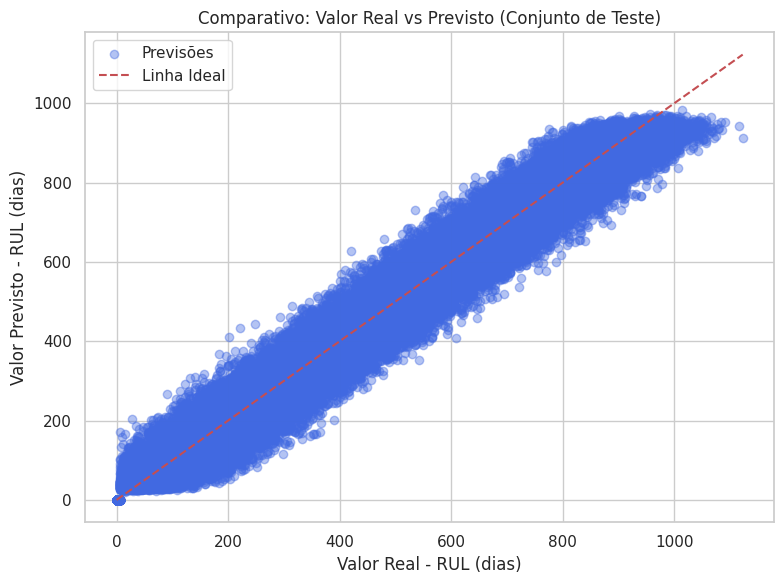

In [83]:
# Inversão do log1p
y_test_real = np.expm1(y_test)
y_test_pred_real = np.expm1(final_test_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_test_pred_real, alpha=0.4, color='royalblue', label='Previsões')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--', label='Linha Ideal')
plt.xlabel('Valor Real - RUL (dias)')
plt.ylabel('Valor Previsto - RUL (dias)')
plt.title('Comparativo: Valor Real vs Previsto (Conjunto de Teste)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**No gráfico acima percebemos que a maioria dos pontos está bem distribuída ao redor da linha y = x, indicando que o modelo está fazendo previsões precisas para o tempo de vida útil restante (RUL) das máquinas. O modelo manteve uma boa capacidade de previsão tanto para máquinas prestes a falhar quanto para aquelas com longa vida útil restante.**

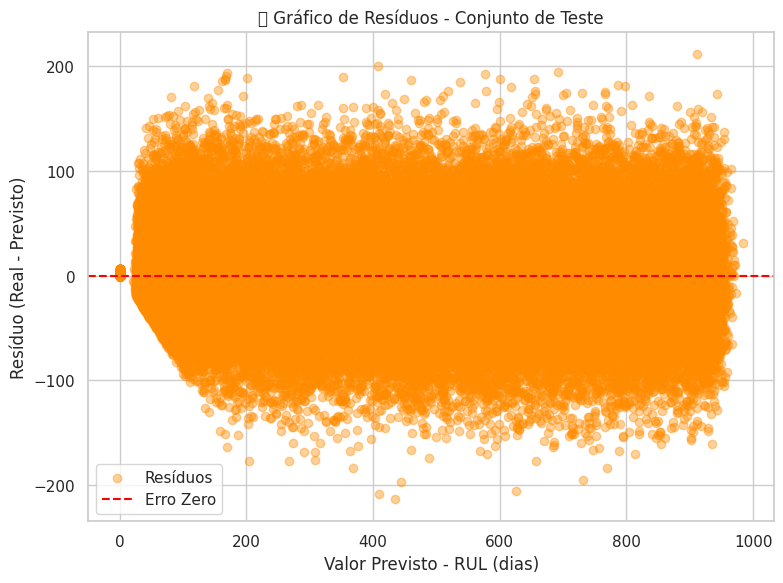

In [84]:
# Cálculo dos resíduos
residuos = y_test_real - y_test_pred_real

# Gráfico de Resíduos
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred_real, residuos, alpha=0.4, color='darkorange', label='Resíduos')
plt.axhline(0, color='red', linestyle='--', label='Erro Zero')
plt.xlabel('Valor Previsto - RUL (dias)')
plt.ylabel('Resíduo (Real - Previsto)')
plt.title('🔍 Gráfico de Resíduos - Conjunto de Teste')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Acima notamos que a maioria dos resíduos está centralizada em torno de 0, o que é ótimo. A dispersão está relativamente constante ao longo da escala dos valores previstos, sugerindo que o modelo não apresenta heterocedasticidade forte (variação de erro que aumenta com a magnitude da previsão)**

**No próximo passo, vamos classificar a máquinas que estáo preste a falhar em 7 dias.**

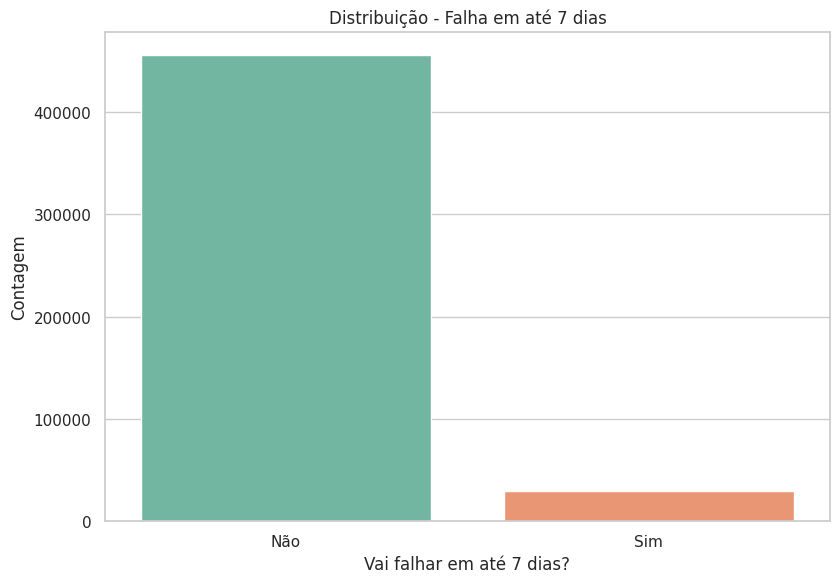

In [85]:
# Analisando novamente o balanceamento da variável alvo
plt.subplot(1, 2, 2)
sns.countplot(x='Failure_Within_7_Days', data=df, palette='Set2')
plt.title('Distribuição - Falha em até 7 dias')
plt.xlabel('Vai falhar em até 7 dias?')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

In [86]:
# Separando features e alvo
X_class = df.drop(columns=['Failure_Within_7_Days', 'Remaining_Useful_Life_days', 'Remaining_Useful_Life_days_log'])
y_class = df['Failure_Within_7_Days']

In [87]:
# Dividindo novamente em treino, validção e teste
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(
    X_class, y_class, test_size=0.30, random_state=42, stratify=y_class
)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(
    X_temp_class, y_temp_class, test_size=0.50, random_state=42, stratify=y_temp_class
)

In [88]:
# Codificação One-Hot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit apenas no treino
X_train_cat_class = encoder.fit_transform(X_train_class[['Machine_Type']])
X_val_cat_class = encoder.transform(X_val_class[['Machine_Type']])
X_test_cat_class = encoder.transform(X_test_class[['Machine_Type']])

encoded_cols = encoder.get_feature_names_out(['Machine_Type'])

In [89]:
# Remove coluna original e junta com codificada
X_train_num_class = X_train_class.drop(columns=['Machine_Type']).reset_index(drop=True)
X_val_num_class = X_val_class.drop(columns=['Machine_Type']).reset_index(drop=True)
X_test_num_class = X_test_class.drop(columns=['Machine_Type']).reset_index(drop=True)

X_train_class_encoded = pd.concat([
    X_train_num_class.reset_index(drop=True),
    pd.DataFrame(X_train_cat_class, columns=encoded_cols).reset_index(drop=True)
], axis=1)

X_val_class_encoded = pd.concat([
    X_val_num_class.reset_index(drop=True),
    pd.DataFrame(X_val_cat_class, columns=encoded_cols).reset_index(drop=True)
], axis=1)

X_test_class_encoded = pd.concat([
    X_test_num_class.reset_index(drop=True),
    pd.DataFrame(X_test_cat_class, columns=encoded_cols).reset_index(drop=True)
], axis=1)

In [90]:
# Padronização
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class_encoded)
X_val_class_scaled = scaler_class.transform(X_val_class_encoded)
X_test_class_scaled = scaler_class.transform(X_test_class_encoded)

In [91]:
# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal_class, y_train_bal_class = smote.fit_resample(X_train_class_scaled, y_train_class)

# Verificando distribuição balanceada
from collections import Counter
print("Distribuição após SMOTE:", Counter(y_train_bal_class))

Distribuição após SMOTE: Counter({0: 318985, 1: 318985})


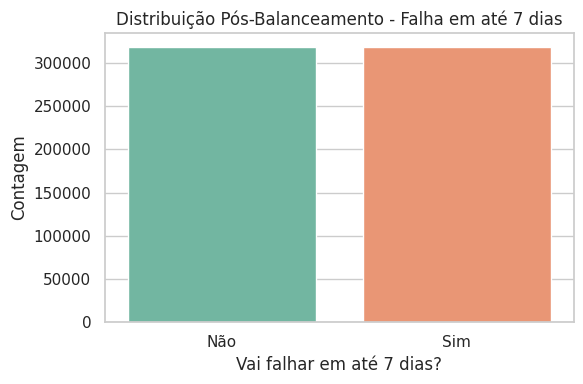

In [92]:
# Analisando novamente o balanceamento da variável alvo
df_bal = pd.DataFrame({'Failure_Within_7_Days': y_train_bal_class})
plt.figure(figsize=(6, 4))
sns.countplot(x='Failure_Within_7_Days', data=df_bal, palette='Set2')
plt.title('Distribuição Pós-Balanceamento - Falha em até 7 dias')
plt.xlabel('Vai falhar em até 7 dias?')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

In [93]:
# Treinamento do XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb.fit(X_train_bal_class, y_train_bal_class)

# Probabilidades
xgb_val_probs = xgb.predict_proba(X_val_class_scaled)[:, 1]
xgb_test_probs = xgb.predict_proba(X_test_class_scaled)[:, 1]

# Threshold personalizado
threshold = 0.10

# Converte as probabilidades em predições binárias com o threshold definido
xgb_val_preds = (xgb_val_probs >= threshold).astype(int)
xgb_test_preds = (xgb_test_probs >= threshold).astype(int)

# Avaliação
print("\n⚡ Avaliação - XGBoost")

print("\n📊 Validação:")
print("Accuracy:", accuracy_score(y_val_class, xgb_val_preds))
print("Precision:", precision_score(y_val_class, xgb_val_preds))
print("Recall:", recall_score(y_val_class, xgb_val_preds))
print("F1 Score:", f1_score(y_val_class, xgb_val_preds))
print("ROC AUC:", roc_auc_score(y_val_class, xgb_val_probs))

print("\n📊 Teste:")
print("Accuracy:", accuracy_score(y_test_class, xgb_test_preds))
print("Precision:", precision_score(y_test_class, xgb_test_preds))
print("Recall:", recall_score(y_test_class, xgb_test_preds))
print("F1 Score:", f1_score(y_test_class, xgb_test_preds))
print("ROC AUC:", roc_auc_score(y_test_class, xgb_test_probs))



⚡ Avaliação - XGBoost

📊 Validação:
Accuracy: 0.9230377867004015
Precision: 0.43709627806828666
Recall: 0.9755148741418764
F1 Score: 0.6036960985626283
ROC AUC: 0.9818368640063249

📊 Teste:
Accuracy: 0.9219789890545075
Precision: 0.4338474025974026
Recall: 0.9784897025171625
F1 Score: 0.6011528187825109
ROC AUC: 0.9815193990445085


**Precision (Precisão):** Entre os casos em que o modelo previu falha, 43,7% em validação e 43,4% em teste eram realmente falhas. Isso significa que, a cada 100 alertas de falha, cerca de 43 são verdadeiros positivos. Embora não seja uma precisão altíssima, ela é aceitável para aplicações industriais, principalmente quando o objetivo é priorizar a detecção de falhas reais e minimizar os falsos negativos. Em ambientes críticos, é preferível emitir alguns falsos alertas do que deixar uma falha passar despercebida.

**Recall (Sensibilidade):** O modelo acertou 97,5% das falhas reais em validação e 97,8% em teste, o que mostra excelente sensibilidade. Ou seja, praticamente todas as falhas reais foram identificadas, mesmo com o threshold ajustado para ser mais conservador. Essa é uma métrica fundamental para aplicações como manutenção preditiva, pois falhas não detectadas podem gerar paradas graves ou acidentes.

**F1 Score (Equilíbrio entre Precision e Recall):** O F1 Score foi de 60,4% em validação e 60,1% em teste, demonstrando que o modelo alcançou um bom equilíbrio entre precisão e sensibilidade, mesmo lidando com um dataset desbalanceado. Esse equilíbrio é essencial para garantir alertas confiáveis sem excesso de intervenções desnecessárias.

**ROC AUC (Área sob a Curva ROC):** O modelo obteve 0.98 tanto em validação quanto em teste, indicando altíssimo poder discriminativo entre as classes. Valores próximos de 1.0 confirmam que o modelo é extremamente confiável para separar máquinas com e sem falha sob diferentes limiares de decisão.

**Accuracy (Acurácia):** A acurácia foi de 92,3% em validação e 92,2% em teste, o que parece excelente à primeira vista. Porém, como estamos lidando com um problema desbalanceado, essa métrica não deve ser analisada isoladamente — afinal, o modelo pode acertar a maioria dos casos simplesmente prevendo "sem falha". Por isso, as demais métricas (recall, F1 e AUC) são mais representativas neste cenário

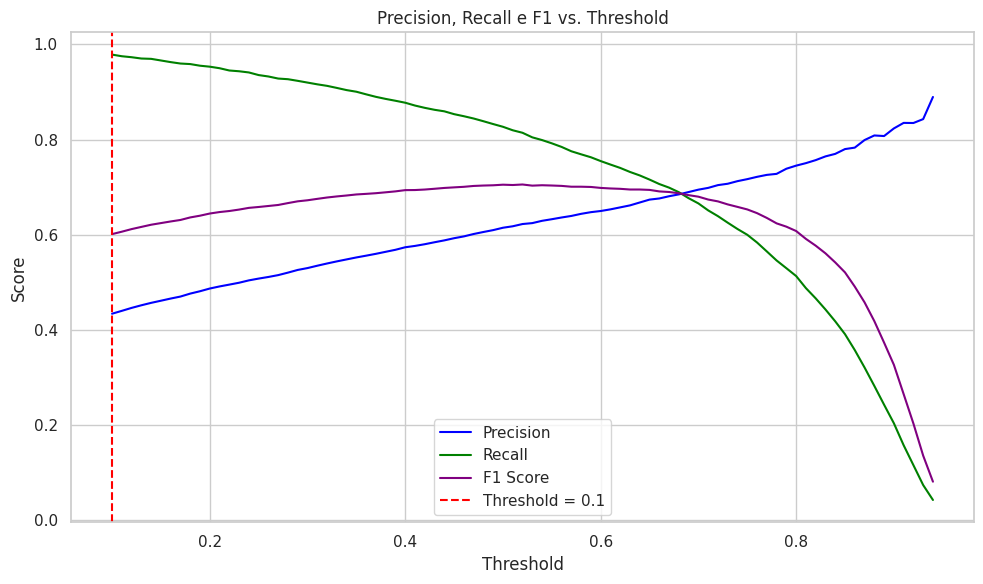

In [94]:
thresholds = np.arange(0.1, 0.95, 0.01)
precision_vals = []
recall_vals = []
f1_vals = []

for t in thresholds:
    preds = (xgb_test_probs >= t).astype(int)
    precision_vals.append(precision_score(y_test_class, preds))
    recall_vals.append(recall_score(y_test_class, preds))
    f1_vals.append(f1_score(y_test_class, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_vals, label='Precision', color='blue')
plt.plot(thresholds, recall_vals, label='Recall', color='green')
plt.plot(thresholds, f1_vals, label='F1 Score', color='purple')
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold = 0.1')
plt.title('Precision, Recall e F1 vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**O gráfico acima confirma as métricas:**

**Precision:** Aumenta conforme o modelo se torna mais conservador (threshold).

**Recall:** Cai com thresholds altos (menos falhas detectadas).

**F1 Score:** Ponto ótimo de equilíbrio entre precisão e recall.

**O modelo está bem ajustado entre segurança operacional e confiabilidade de alerta, exatamente o que se espera em ambientes industriais reais de manutenção preditiva.**

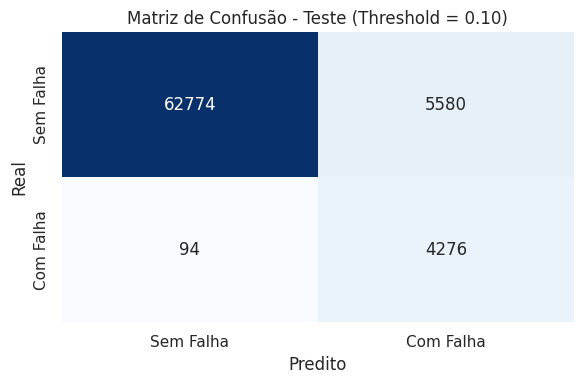

In [95]:
# Matriz de confusão
threshold_otimo = 0.10
y_test_pred_adjusted = (xgb_test_probs > threshold_otimo).astype(int)

conf_matrix = confusion_matrix(y_test_class, y_test_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sem Falha', 'Com Falha'],
            yticklabels=['Sem Falha', 'Com Falha'])
plt.title(f'Matriz de Confusão - Teste (Threshold = {threshold_otimo:.2f})')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

**Na matriz de confusão apresentada, observamos que o modelo identificou corretamente 62.774 casos sem falha, ou seja, verdadeiros negativos. Além disso, conseguiu detectar 4.276 falhas reais com sucesso, representando os verdadeiros positivos. Por outro lado, o modelo gerou 5.580 falsos positivos, ou seja, casos em que foi emitido um alerta de falha, mas a máquina estava operando normalmente. Apesar desse número parecer alto, ele é aceitável em um cenário industrial crítico, pois prioriza a detecção antecipada de falhas reais.**

**O número de falsos negativos foi de apenas 94, o que significa que pouquíssimas falhas reais passaram despercebidas, uma performance altamente desejável em aplicações de missão crítica. Com recall acima de 97% e uma precisão de aproximadamente 63%, o modelo demonstra excelente sensibilidade, sendo altamente confiável para sistemas de manutenção preditiva onde o custo de não detectar uma falha é muito maior do que o custo de um falso alarme.**

**No próximo passo iremos unir os dois modelos e criar uma visão integrada de risco, respondendo: Quais máquinas vão falhar, e em quantos dias essa falha deve acontecer?**

In [96]:
# Reverte a transformação log1p para obter a vida útil estimada em dias
predicted_rul = np.expm1(final_test_pred)  # final_test_pred vem do modelo híbrido de regressão

# Aplica o modelo de classificação com threshold ajustado
threshold = 0.10
failure_probs = xgb_test_probs
failure_pred = (failure_probs >= threshold).astype(int)

# Cria DataFrame com os resultados combinados e alinha pelo índice correto
result_df = pd.DataFrame({
    'Predicted_RUL_days': predicted_rul,
    'Failure_Probability': failure_probs,
    'Failure_Prediction': failure_pred
}, index=X_test_class.index)

# Recupera Machine_Type a partir do X_test_class (índice correto + ainda não codificado)
result_df['Machine_Type'] = X_test_class['Machine_Type']

# Converte dias decimais em formato 'X dias e Y horas'
def format_days_hours(days):
    d = int(days)
    h = int((days - d) * 24)
    return f"{d} dias e {h} horas"

result_df['Predicted_RUL_formatado'] = result_df['Predicted_RUL_days'].apply(format_days_hours)

# Reorganiza colunas para apresentação
result_df = result_df[['Machine_Type', 'Predicted_RUL_days', 'Predicted_RUL_formatado',
                       'Failure_Probability', 'Failure_Prediction']]

# Ordena por estado crítico (prioriza quem vai falhar mais rápido)
result_df_sorted = result_df.sort_values(
    by=['Failure_Prediction', 'Predicted_RUL_days', 'Failure_Probability'],
    ascending=[False, True, False]
)

# Exibindo
print("🔍 TOP 10 MÁQUINAS CRÍTICAS - ALERTA DE FALHA IMINENTE")
display(
    result_df_sorted.head(500)
    .style.set_caption("🚨 Máquinas com Alta Probabilidade de Falha")
    .background_gradient(cmap="Reds", subset=['Failure_Probability'])
)


🔍 TOP 10 MÁQUINAS CRÍTICAS - ALERTA DE FALHA IMINENTE


,Machine_Type,Predicted_RUL_days,Predicted_RUL_formatado,Failure_Probability,Failure_Prediction
429213,Labeler,-0.018796,0 dias e 0 horas,0.717242,1
349865,CNC_Mill,-0.009347,0 dias e 0 horas,0.156424,1
69528,Hydraulic_Press,-0.001623,0 dias e 0 horas,0.139249,1
463816,Grinder,-0.001269,0 dias e 0 horas,0.936946,1
177241,XRay_Inspector,-0.001112,0 dias e 0 horas,0.180974,1
12652,Grinder,0.004036,0 dias e 0 horas,0.222766,1
457503,Grinder,0.005922,0 dias e 0 horas,0.680252,1
219836,Crane,0.006422,0 dias e 0 horas,0.563582,1
407296,Press_Brake,0.006432,0 dias e 0 horas,0.222042,1
307963,Carton_Former,0.008980,0 dias e 0 horas,0.774993,1
